#### 1. What Does Quantization Do?
Quantization maps floating-point numbers (`float32`) to lower-precision integers (`int8`). This is one of the possibilities and several other exist. In this case, this involves:
- **Scaling:** Mapping the range of `float32` values to the range of `int8` (-128 to 127).
- **Rounding:** Converting decimal values to the nearest integer.

#### 2. Why Does This Make Sense?
- **Efficiency:** `float32` weights take 4 bytes per weight, while `int8` weights take 1 byte. This reduces model size and improves performance, especially on resource-constrained devices.
| **Number of Weights** | **Model Size (float32)** | **Model Size (int8)** | **Space Saved (in %)** |
|-----------------------|--------------------------|-----------------------|------------------------|
| 1 Million (1M)        | 4MB (4 bytes * 1M)       | 1MB (1 byte * 1M)      | 75%                    |
| 1 Billion (1B)        | 4GB (4 bytes * 1B)       | 1GB (1 byte * 1B)      | 75%                    |
| 70 Billion (70B)      | 280GB (4 bytes * 70B)    | 70GB (1 byte * 70B)    | 75%                    |

By converting from `float32` to `int8`, the memory and disk space requirements are reduced by approximately 75%, as each weight is reduced from 4 bytes to 1 byte.

- **Performance:** The loss of precision often has minimal impact on the model's accuracy. More on this is discuss below.

#### 3. Quantization Process Example
#### Step-by-Step:
1. Calculate a **scaling factor** to map the `float32` range to the `int8` range.
2. Multiply each `float32` value by the scaling factor.
3. Round the result to the nearest integer.

#### Example:
Let’s assume the scaling factor is `1000` (simplified for illustration).

- `float32 weight = 0.00431718`
  - Scale: `0.00431718 * 1000 = 4.31718`
  - Round: `4`
  - `int8 weight = 4`

- `float32 weight = -0.03002159`
  - Scale: `-0.03002159 * 1000 = -30.02159`
  - Round: `-30`
  - `int8 weight = -30`

#### 4. Sample Conversion Breakdown
Assume the model has the following `float32` weights:

**Original Float32 Weights (First Dense Layer):**
```python
[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]
```

After quantization, with scaling and rounding (scale=1000 in this example):

**Quantized Int8 Weights:**
```python
[[ 4, -30, -19, 34, 15 ]]
```

#### How Do We Decide the Scaling Factor?

1. **Analyze the Range of Float32 Weights:**
   - Determine the **minimum** and **maximum** values in the float32 weight matrix.
   - Example: If the weights range from `-0.1` to `0.1`, the scaling factor needs to stretch this range to fit within the `int8` range `[-128, 127]`.

2. **Compute the Scaling Factor:**
   - A scaling factor `S` is calculated as:
     \[
     S = \frac{\text{max}(\text{abs}(\text{weights}))}{127}
     \]
   - This ensures the largest weight in the float32 matrix maps to `127`, the upper limit of `int8`.

3. **Quantize the Weights:**
   - Each weight is divided by `S` and rounded to the nearest integer.

4. **Dequantize During Inference:**
   - The int8 weights are scaled back to approximate float32 values during inference using the inverse of the scaling factor \( S^{-1} \).

#### Limitations of This Approach

1. **Loss of Precision:**
   - Fine-grained differences in small weights might be lost when mapping to integers, potentially impacting performance in models highly sensitive to weight precision.

2. **Dynamic Range:**
   - Models with weights that span a wide dynamic range (e.g., very large and very small values) may suffer because a single scaling factor might not effectively represent all values.

3. **Activation Quantization Challenges:**
   - Activations (intermediate layer outputs) are also quantized, and their dynamic range can vary between inputs, leading to additional quantization errors.

4. **Bias Quantization:**
   - Bias terms in the model may require higher precision because small changes can have a significant impact. These are often kept in `float32` to mitigate accuracy loss.

5. **Model-Specific Sensitivity:**
   - Some models (e.g., those with small weights near zero or those with fine-grained layer dependencies) may degrade more in accuracy than others.

6. **Hardware Dependence:**
   - The performance gain depends on the hardware’s ability to optimize for int8 computations. Some devices may not fully support int8 arithmetic.

#### How to Mitigate Limitations

- **Use Per-Tensor Scaling:**
  - Assign different scaling factors for each tensor or layer to better adapt to their specific ranges.
  
- **Use Quantization-Aware Training:**
  - Simulate quantization effects during training to adjust the model’s weights for better post-quantization performance.

- **Post-Training Calibration:**
  - Run calibration with representative data to determine optimal scaling factors.

- **Mixed-Precision Quantization:**
  - Keep critical parts of the model (e.g., biases, certain layers) in higher precision (e.g., float16) while quantizing the rest to int8.

By carefully choosing the scaling factor and mitigating limitations, quantization can achieve a good balance between model size, efficiency, and accuracy.


#### Types of Quantization in Machine Learning

#### 1. Post-Training Static Quantization
- **What it Does:** Converts weights and activations to lower precision (e.g., `float32` → `int8`) after training.
- **How it Works:** Uses representative data to determine scaling factors for weights and activations.
- **Space Savings:** ~75% (e.g., float32 → int8).
- **Precision Loss:** Moderate; dependent on model structure and dynamic range.

#### 2. Post-Training Dynamic Range Quantization
- **What it Does:** Converts weights to int8 but leaves activations in float32 for dynamic scaling.

    - **Weights**: These are the parameters of the model that are learned during training. They represent the strength of connections between neurons in different layers of the network. In neural networks, weights are multiplied with the input data to produce output.

        **Example**: 
        - In a dense layer, weights could look like: `[ 0.23, -1.45, 0.78 ]`.

    - **Activations**: These are the outputs of each layer (except the final output layer). After input data is processed through the layer's weights, the activation function is applied to the result. Activations represent the transformed information passed between layers.

        **Example**: 
        - After applying weights to input data and the activation function, activations might look like: `[ 0.32, 0.47, 0.15 ]`.

Let's consider a simple feedforward neural network used for classifying images (like MNIST digits).

#### Model Architecture:
- **Input Layer**: 28x28 pixel image (784 features)
- **Hidden Layer 1**: 128 neurons
- **Hidden Layer 2**: 64 neurons
- **Output Layer**: 10 neurons (representing the 10 possible digit classes)

#### Weights:
- **What are they?**
  Weights are the parameters of the network that are learned during training. In each layer, each connection between neurons has a weight that determines how much influence one neuron has on another.
  
- **In Our Example:**
  - Between the input layer and hidden layer 1, each of the 784 input neurons has a weight for each of the 128 hidden layer neurons. This means there are `784 * 128 = 100,352` weights.
  - Similarly, between hidden layer 1 and hidden layer 2, there are `128 * 64 = 8,192` weights.
  - Between hidden layer 2 and the output layer, there are `64 * 10 = 640` weights.
  
  **Total number of weights in the model = 100,352 + 8,192 + 640 = 109,184 weights.**

  **Example Weights:**
  - Between input and first hidden layer: `[ 0.01, -0.23, 0.45, -0.56, ... ]`
  - Between the first hidden layer and second hidden layer: `[ 0.32, -0.44, 0.13, ... ]`
  - Between the second hidden layer and the output layer: `[ 0.03, 0.19, -0.56, ... ]`

#### Activations:
- **What are they?**
  Activations are the outputs of each layer after applying the layer's weights and the activation function. They represent the information that gets passed from one layer to the next during the forward pass of the network.

- **In Our Example:**
  - The input image (28x28 pixels) is flattened into a 784-dimensional vector. This vector is multiplied by the weights of the input-hidden layer connections, and the result is passed through an activation function (e.g., ReLU).
  - The activations for hidden layer 1 are the outputs of this activation function, which are passed to the next layer.
  - The activations for the output layer are the final outputs of the network, which represent the predicted class probabilities.

  **Example Activations:**
  - After the input layer and hidden layer 1 computation, the activations might look like: `[ 0.65, 0.23, 0.01, ... ]`
  - After hidden layer 2: `[ 0.89, 0.45, 0.74, ... ]`
  - Final activations (output layer): `[ 0.12, 0.56, 0.23, 0.09, ... ]` (These represent class probabilities for the 10 digit classes).

The number of weights between layers depends on the number of neurons in the current and next layers. For example, if you have 128 neurons in the current layer and 64 neurons in the next layer, you will have `128 * 64 = 8,192` weights.

The number of activations corresponds to the number of neurons in the layer, not the number of connections (weights). For instance, if you have 128 neurons in the layer, you will have 128 activations.


In short, **weights** determine the transformation applied to the input data, while **activations** represent the intermediate results of those transformations that are passed between layers.

- **How it Works:** Uses dynamic range information at runtime to scale activations.
- **Space Savings:** ~50% (weights only reduced to int8).
- **Precision Loss:** Low; suitable for most applications.

#### 3. Quantization-Aware Training (QAT)
- **What it Does:** Simulates quantization during training to adapt weights for lower precision.
- **How it Works:** Introduces fake quantization nodes in the training graph to mimic int8 behavior.
In QAT, for instance, a weight value of `0.123` might be simulated as `0.125` during training to mimic the effect of quantization. After training, the model is then quantized to the desired precision (e.g., int8) for deployment.

In a standard training process, weights are updated in full precision (e.g., `float32`). However, in QAT, fake quantization nodes are inserted between layers, causing the weights and activations to behave as if they were quantized (e.g., converted to int8 or float16). This means that during forward propagation, the values passed between layers are simulated as quantized values. For example:

- The model’s weights might be represented as `0.1234` during normal training, but during QAT, they might behave as `0.125` (simulating rounding).
- During backward propagation, gradients are also adjusted with the quantized values in mind.

This process helps the model learn to tolerate precision loss and adapt its weights to retain performance when later quantized to a fixed precision (e.g., int8) after training. After training, the weights can be converted to lower precision (e.g., int8), but because the model was trained with quantization effects, it can often retain most of its accuracy despite the lower precision.

- **Space Savings:** ~75%.
- **Precision Loss:** Minimal; achieves near float32 accuracy if done correctly.

#### 4. Per-Tensor Quantization
- **What it Does:** Uses a single scaling factor for an entire tensor (layer-wise quantization).
- **How it Works:** Scales all weights/activations in a tensor uniformly.
- **Space Savings:** Same as static quantization (~75%).
- **Precision Loss:** Moderate; less accurate for tensors with wide dynamic ranges.

#### 5. Per-Channel Quantization
- **What it Does:** Applies different scaling factors per channel in a tensor.
- **How it Works:** Improves representation for wide dynamic ranges by scaling each channel separately.
- **Space Savings:** ~75%.
- **Precision Loss:** Low; better than per-tensor quantization for models with wide dynamic ranges.

#### 6. Mixed-Precision Quantization
- **What it Does:** Combines multiple precisions (e.g., float16 for activations, int8 for weights).
- **How it Works:** Selects precision per layer based on sensitivity and hardware support.
- **Space Savings:** ~50%-75%, depending on configuration.
- **Precision Loss:** Low; tuned for accuracy-sensitive layers.

#### 7. Weight Clustering/Shared Quantization
- **What it Does:** Groups weights into clusters and uses a single shared value for each cluster.
- **How it Works:** Reduces the number of unique weights, typically followed by lookup tables.
- **Space Savings:** Up to 75% or more.
- **Precision Loss:** High; depends on the number of clusters.

#### 8. Binary Quantization
- **What it Does:** Converts weights and activations to binary values (`-1, +1`).
- **How it Works:** Uses sign-based representation instead of real-valued weights.
- **Space Savings:** ~87.5% (e.g., float32 → 1-bit).
- **Precision Loss:** Very High; significant accuracy drop for complex models.

#### 9. Ternary Quantization
- **What it Does:** Converts weights to ternary values (`-1, 0, +1`).
- **How it Works:** Introduces zero weights for sparsity and smaller size.
- **Space Savings:** ~85%-90%.
- **Precision Loss:** Very High; more accurate than binary quantization but still limited.

#### 10. Quantized Embedding Tables
- **What it Does:** Quantizes embedding vectors for memory efficiency.
- **How it Works:** Uses per-row scaling or lookup tables for embeddings.
- **Space Savings:** ~50%-75%.
- **Precision Loss:** Low to moderate; depends on embedding size and task.

#### 11. Hybrid Quantization
- **What it Does:** Quantizes specific parts of the model (e.g., weights) while keeping others (e.g., biases) in higher precision.
- **How it Works:** Tailored to balance accuracy and space savings.
- **Space Savings:** ~50%-75%.
- **Precision Loss:** Low to moderate.

#### 12. Stochastic Quantization
- **What it Does:** Introduces randomness in quantization by probabilistically rounding values.
- **How it Works:** Reduces bias from deterministic rounding errors.
- **Space Savings:** Same as static quantization (~75%).
- **Precision Loss:** Moderate; slightly better for noisy data.

#### 13. Sparsity-Induced Quantization
- **What it Does:** Combines pruning and quantization to leverage sparse weights.
- **How it Works:** Prunes insignificant weights and quantizes the remaining ones.
- **Space Savings:** Up to 90%.
- **Precision Loss:** Moderate; sparsity introduces additional accuracy challenges.


#### Most Commonly Used Quantization Methods

#### 1. **Post-Training Static Quantization**
- **Why Common:** Simple to implement and widely supported by tools like TensorFlow Lite and PyTorch.
- **Typical Use Case:** Deployment on edge devices where memory and power are constrained.
- **Trade-Off:** Moderate precision loss but good balance of accuracy and efficiency.

#### 2. **Post-Training Dynamic Range Quantization**
- **Why Common:** Easiest to apply without requiring representative datasets for calibration.
- **Typical Use Case:** Quick optimization for edge deployment or experimentation.
- **Trade-Off:** Lower space savings compared to static quantization, with minimal accuracy loss.

#### 3. **Quantization-Aware Training (QAT)**
- **Why Common:** Achieves near float32 accuracy with int8 models.
- **Typical Use Case:** High-performance, accuracy-critical applications.
- **Trade-Off:** Requires retraining, which can be computationally expensive.

#### 4. **Per-Channel Quantization**
- **Why Common:** Improves accuracy for models with wide dynamic ranges, such as vision models.
- **Typical Use Case:** Advanced models for vision or audio tasks.
- **Trade-Off:** Slightly more complex implementation but minimal precision loss.
- **What it Does:** In per-channel quantization, each channel (e.g., R, G, B for an image) is quantized independently rather than applying the same quantization scale across all channels. This method assigns separate scaling factors to each channel, allowing the model to better handle differences in dynamic range between channels.
  
**Example with Image Data:**
For an image, each pixel typically has 3 values corresponding to the Red (R), Green (G), and Blue (B) channels. In per-channel quantization:
- The Red channel may have a dynamic range from 0 to 255.
- The Green channel might have a dynamic range from 0 to 200.
- The Blue channel may have a dynamic range from 0 to 180.

Instead of quantizing the entire pixel with one common scale factor (which might distort the individual channels), each channel is quantized independently with its own scale factor to preserve the unique dynamic range of each.

- **Why Common:** It improves the accuracy of models, especially in domains like computer vision, where different channels (like RGB in images) may have very different value ranges.
  
- **Typical Use Case:** This is widely used in vision models where images consist of multiple channels (e.g., RGB, or even more channels in specialized tasks like multispectral or medical imaging).

- **Trade-Off:** Per-channel quantization requires slightly more complex implementation compared to per-tensor quantization (where one scale is used for all channels). However, the performance trade-off is minimal, and accuracy is usually much better since each channel is treated separately based on its characteristics.

#### 5. **Mixed-Precision Quantization**
- **Why Common:** Supported by modern hardware (e.g., NVIDIA GPUs, TPUs) for optimal efficiency.
- **Typical Use Case:** Large-scale models where space and computational efficiency matter.
- **Trade-Off:** Requires tuning and hardware compatibility.

#### Possible Quantization Conversions with Space Savings, Accuracy Loss, and Examples

#### 1. **float32 → int8**
- **Space Saved:** ~75% (4 bytes → 1 byte per value)
- **Accuracy Loss:** Minimal (~1-2%) with proper calibration and representative datasets.
- **Range:** int8 values range from -128 to 127.
- **Example:**
  - float32: `[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]`
  - int8: `[[ 4, -30, -19, 34, 15 ]]`
    **Explanation:** The int8 representation allows for both positive and negative values (i.e., signed integers), making it suitable for data where both positive and negative values are important.


#### 2. **float32 → float16**
- **Space Saved:** ~50% (4 bytes → 2 bytes per value)
- **Accuracy Loss:** Negligible (<1%) for most models.
- **Example:**
  - float32: `[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]`
  - float16: `[[ 0.0043, -0.03, -0.019, 0.034, 0.015 ]]`

#### 3. **float32 → uint8**
- **Space Saved:** ~75% (4 bytes → 1 byte per value)
- **Accuracy Loss:** Minimal (~1-2%).
- **Range:** uint8 values range from 0 to 255 (only positive values).
- **Example:**
  - float32: `[[ 0.00431718, 0.03002159, 0.01927675, 0.03434618, 0.0154517 ]]`
  - uint8: `[[ 4, 30, 19, 34, 15 ]]`
    **Explanation:** The uint8 representation only handles positive values (i.e., unsigned integers), so it's best used for data that does not need to represent negative numbers, such as images with pixel values or other non-negative quantities.

#### 4. **float32 → int16**
- **Space Saved:** ~50% (4 bytes → 2 bytes per value)
- **Accuracy Loss:** Very low (~<1%).
- **int16** (signed 16-bit integer) has a range of:
  - **Minimum:** -32,768
  - **Maximum:** 32,767
- **Example:**
  - float32: `[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]`
  - int16: `[[ 43, -300, -193, 343, 155 ]]`

#### 5. **float32 → binary (1-bit)**
- **Space Saved:** ~97% (4 bytes → 1 bit per value)
- **Accuracy Loss:** Significant (~5-10% or higher).
- **Example:**
  - float32: `[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]`
  - binary: `[[ 1, -1, -1, 1, 1 ]]`

#### 6. **float32 → ternary (2-bit)**
- **Space Saved:** ~94% (4 bytes → 2 bits per value)
- **Accuracy Loss:** Moderate (~3-5%).
- **Example:**
  - float32: `[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]`
  - ternary: `[[ 1, -1, -1, 1, 0 ]]`

#### 7. **float16 → int8**
- **Space Saved:** ~50% (2 bytes → 1 byte per value)
- **Accuracy Loss:** Minimal (~1-2%).
- **Example:**
  - float16: `[[ 0.0043, -0.03, -0.019, 0.034, 0.015 ]]`
  - int8: `[[ 4, -30, -19, 34, 15 ]]`

#### 8. **float64 → float32**
- **Space Saved:** ~50% (8 bytes → 4 bytes per value)
- **Accuracy Loss:** Negligible (<1%).
- **Example:**
  - float64: `[[ 0.004317182431221, -0.030021592843127, -0.01927675346211, 0.03434618742121, 0.01545171212451 ]]`
  - float32: `[[ 0.00431718, -0.03002159, -0.01927675, 0.03434618, 0.0154517 ]]`

#### 9. **float64 → int8**
- **Space Saved:** ~87.5% (8 bytes → 1 byte per value)
- **Accuracy Loss:** High (~5-10% or more).
- **Example:**
  - float64: `[[ 0.004317182431221, -0.030021592843127, -0.01927675346211, 0.03434618742121, 0.01545171212451 ]]`
  - int8: `[[ 4, -30, -19, 34, 15 ]]`

#### 10. **int32 → int16**
- **Space Saved:** ~50% (4 bytes → 2 bytes per value)
- **Accuracy Loss:** Negligible (<1%).
- **Example:**
  - int32: `[[ 4321, -30021, -19276, 34346, 15545 ]]`
  - int16: `[[ 4321, -30021, -19276, 34346, 15545 ]]`

#### 11. **int32 → int8**
- **Space Saved:** ~75% (4 bytes → 1 byte per value)
- **Accuracy Loss:** Minimal (~1-2%).
- **Example:**
  - int32: `[[ 4321, -30021, -19276, 34346, 15545 ]]`
  - int8: `[[ 43, -30, -19, 34, 15 ]]`


#### Explanation of Quantization: How It Works, Why It Works, and Usage During Inference

#### **How It Was Done**
1. **Scaling and Zero Point:**
   - **Scaling Factor:** Quantization maps the original floating-point range (e.g., -1 to 1) to an integer range (e.g., -128 to 127 for int8). 
     - Example: Multiply floating-point weights by a scaling factor (e.g., 1000 for float32 → int8).
   - **Zero Point:** A small offset (usually 0 for symmetric quantization) is added to align the integer representation with the floating-point range.

   Formula:
   $$\text{quantized\_value} = \text{round}(\text{float\_value} \times \text{scale}) + \text{zero\_point}$$

2. **Dequantization During Inference:**
   - The integer values are scaled back to approximate the original floating-point range using:
   $$\text{float\_value} \approx (\text{quantized\_value} - \text{zero\_point}) / \text{scale}$$

3. **Quantized Model Conversion:**
   - During model conversion (e.g., TensorFlow Lite), weights and activations are quantized using the above mapping. The conversion uses calibration datasets to minimize the loss of precision.

#### **Why It Works**
1. **Neural Networks Are Robust to Small Perturbations:**
   - Neural networks tolerate small numerical changes due to their inherent redundancy, especially for weights and activations.
   - Quantization reduces precision but retains the overall pattern of the weights.

2. **Efficiency in Arithmetic Operations:**
   - Integer arithmetic is faster and consumes less power compared to floating-point arithmetic on most hardware.

3. **Calibration with Representative Datasets:**
   - By calibrating with a representative dataset, the quantization process ensures that the range of weights and activations is well-covered, minimizing the loss in accuracy.

#### **How It Is Used During Inference**
1. **Pre-Quantized Weights:**
   - The model uses the quantized weights and activations directly, stored in integer format.

2. **Integer Arithmetic Operations:**
   - Most modern hardware accelerators (e.g., Tensor cores, Edge TPUs) support fast matrix multiplication and convolutions using integers, speeding up computations.

3. **Dynamic Range Adjustment:**
   - During inference, inputs are scaled to match the range of the quantized model using the same scale and zero point applied during quantization.

4. **Output Conversion:**
   - The final outputs (e.g., logits or probabilities) are dequantized back to floating-point for interpretation.

#### **Key Benefits in Inference**
- **Reduced Model Size:** Smaller memory footprint due to the use of integers instead of floats.
- **Improved Latency:** Faster computations due to optimized integer operations.
- **Lower Power Consumption:** Ideal for edge devices like mobile phones and IoT devices.

#### **Example of Inference Flow**
1. Input image (`float32`) → Quantized to `int8` using scale and zero point.
2. `int8` weights and activations processed in the quantized model.
3. Final output (`int8`) → Dequantized to `float32` for probabilities/logits.

#### **Challenges and Limitations**
- **Loss in Accuracy:**
  - If the quantization range does not capture outliers effectively, accuracy drops.
- **Complexity in Hybrid Models:**
  - Some operations may remain in floating-point (e.g., softmax) in hybrid quantization models, reducing efficiency.
- **Hardware Support:**
  - Quantization works best on hardware designed for integer operations; older hardware may not fully exploit the benefits.

This quantization approach balances the trade-offs between model size, speed, and accuracy, making it highly effective for deploying ML models on resource-constrained devices.

To quantize(GGUF quants) any model on HuggingFace, you can make use of the following repository: https://huggingface.co/spaces/ggml-org/gguf-my-repo

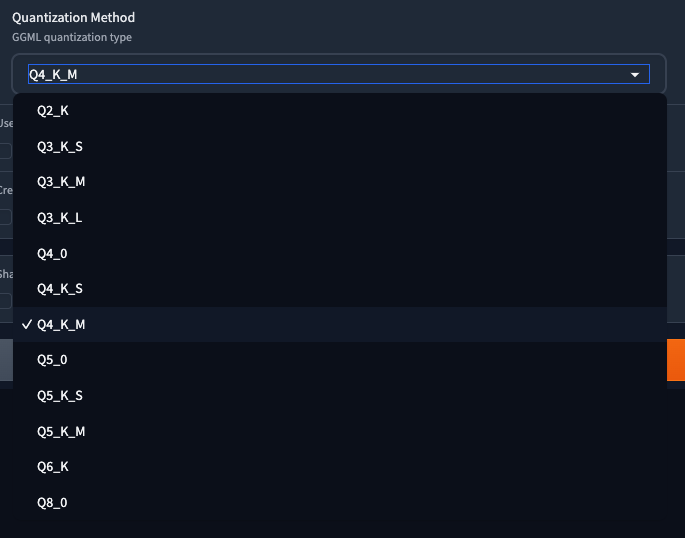

#### What is GGML?

**GGML (General Graph Machine Learning)** is a lightweight framework for running large language models (LLMs) on resource-constrained hardware (e.g., CPUs). It focuses on efficient inference through techniques like **quantization**.

#### GGML Quantization Methods

Quantization reduces model size by lowering weight precision. GGML offers several methods:

- **Q2, Q3, Q4, Q5, Q6, Q8**: Numbers indicate **bits per weight**. Fewer bits mean smaller size but may reduce accuracy.
- **Suffixes**:
  - **_K**: Clustering for optimized quantization.
  - **_S**: Symmetric quantization.
  - **_M**: Mixed precision.
  - **_L**: Logarithmic quantization for better range.

These methods balance performance, size, and accuracy.

#### Are GGML Quantization Methods Related to Graph ML?

No, GGML quantization focuses on LLM efficiency and is unrelated to graph-based machine learning.

#### GGML Quantization Methods

Quantization reduces the precision of numbers in a model (e.g., converting floating-point numbers to integers) to make the model faster and smaller. Below are explanations of the various GGML quantization methods.

#### **Quantization Levels (Prefixes)**
1. **Q2, Q3, Q4, Q5, Q6, Q8**:
   - The number indicates the number of bits per weight.
   - Example:
     - **Q2**: 2-bit quantization (most aggressive compression, less precision).
     - **Q8**: 8-bit quantization (higher precision, less compression).

#### **Quantization Suffixes**
1. **_0**:
   - No additional optimization; straightforward quantization.

2. **_K**:
   - Uses **k-means clustering** to optimize quantized values, grouping weights into clusters.

3. **_S**:
   - Employs **symmetric quantization**, where weights are distributed symmetrically around zero.
   - Reduces computational complexity but might lose some precision for weights close to zero.

4. **_M**:
   - Indicates **mixed quantization**, where different parts of the model use different bit widths.
   - Aims to balance performance and accuracy.

5. **_L**:
   - Stands for **logarithmic quantization**, which compresses weights into logarithmic scales for better dynamic range representation.

#### **How to Choose?**
- **Q2 or Q3**:
  - Best for extremely resource-constrained environments where memory is critical.
  - Expect some accuracy loss.
- **Q4**:
  - Balanced trade-off between compression and accuracy.
  - Commonly used for deploying large models on edge devices.
- **Q5 or Q6**:
  - Higher precision with slightly more memory usage.
- **Q8**:
  - Best for cases where accuracy is critical but memory constraints are less severe.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torchvision import datasets, transforms
import numpy as np

import torch.backends.quantized as quantized
quantized.engine = 'qnnpack'  # or 'fbgemm' based on your system (CPU)
### on macbook m1 pro, ran into error RuntimeError: Didn't find engine for operation quantized::linear_prepack NoQEngine
### looked around and found the above fix

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Define the model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

model = MNISTModel()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 3
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# Evaluate model accuracy on test data
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

float32_accuracy = evaluate_model(model, testloader)
print(f"Float32 Accuracy: {float32_accuracy:.4f}")

# Quantization: Convert model to quantized version
model.eval()  # Ensure the model is in evaluation mode
model_q = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Evaluate quantized model accuracy
quantized_accuracy = evaluate_model(model_q, testloader)
print(f"Int8 Quantized Accuracy: {quantized_accuracy:.4f}")

# Save float32 and int8 models
torch.save(model.state_dict(), "data/model_float32.pth")
torch.save(model_q.state_dict(), "data/model_int8.pth")

# Extract and print weights (for float32 and int8)
print("\nOriginal Float32 Weights (First Linear Layer):")
print(model.fc1.weight.data[:5])  # First 5 weights from the first layer

# Quantized model weights
print("\nQuantized Weights (First Linear Layer - Int8):")
print(model_q.fc1.weight().int_repr()[:5])  # First 5 quantized weights


Epoch 1, Loss: 1.608164205932617
Epoch 2, Loss: 1.5363000733057657
Epoch 3, Loss: 1.5200950430552165
Float32 Accuracy: 0.9428
Int8 Quantized Accuracy: 0.9422

Original Float32 Weights (First Linear Layer):
tensor([[-0.0013,  0.0422,  0.0640,  ...,  0.0558,  0.0469,  0.0614],
        [ 0.0065, -0.0042,  0.0275,  ...,  0.0186,  0.0276, -0.0136],
        [-0.0102,  0.0420,  0.0090,  ...,  0.0005, -0.0235,  0.0396],
        [ 0.0058,  0.0401,  0.0117,  ..., -0.0233, -0.0271, -0.0185],
        [ 0.0034,  0.0239, -0.0205,  ..., -0.0085, -0.0023, -0.0067]])

Quantized Weights (First Linear Layer - Int8):
tensor([[ 0,  8, 11,  ..., 10,  8, 11],
        [ 1, -1,  5,  ...,  3,  5, -2],
        [-2,  8,  2,  ...,  0, -4,  7],
        [ 1,  7,  2,  ..., -4, -5, -3],
        [ 1,  4, -4,  ..., -2,  0, -1]], dtype=torch.int8)


#### Important Points:

- **`quantize_dynamic`**: This method converts only certain layers (like `nn.Linear` in this case) to the specified dtype (e.g., `torch.qint8`). It performs dynamic quantization, meaning it quantizes the weights on the fly during inference.

- **Evaluation Mode**: The model must be in `eval()` mode when applying quantization.

- **Corrected Weight Extraction**: The quantized model uses the `int_repr()` function to access the quantized weights. Make sure you're calling it correctly to avoid errors.
